In [ ]:
!pip install pvlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 21.2 MB/s eta 0:00:00


In [ ]:
# Some warnings appear when calculating the IV-curve because of wrong inputs within a logarithm
# Those two lines, avoid to print the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pvlib
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.iotools import get_pvgis_tmy
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import calendar

In [ ]:
#url="https://raw.githubusercontent.com/Checherection/research-project/refs/heads/main/Flaine_(1600m).csv "
#url="https://raw.githubusercontent.com/Checherection/research-project/refs/heads/main/Couvercle_Nivose_(2758m).csv"
#url="https://raw.githubusercontent.com/Checherection/research-project/refs/heads/main/Chambery_Aix_(235m).csv"
url="https://raw.githubusercontent.com/Checherection/research-project/refs/heads/main/Bourg_Saint_Maurice_(865m).csv"
#url="https://raw.githubusercontent.com/Checherection/research-project/refs/heads/main/Aiguilles_Rouge_Nivose_(2400m).csv"
snow_data = pd.read_csv(url, index_col=0,  header=0,sep=';')

IP_Tilt_Angle = 5
IP_Surface_Azimuth = 180

print(snow_data)

           neige_au_sol  snow_total  snow_event  Unnamed: 4  Unnamed: 5  \
january             195          30           3         NaN         NaN   
february              0           0           0         NaN         NaN   
march                11          10           1         NaN         NaN   
april                 0           0           0         NaN         NaN   
may                   0           0           0         NaN         NaN   
june                  0           0           0         NaN         NaN   
july                  0           0           0         NaN         NaN   
august                0           0           0         NaN         NaN   
september             0           0           0         NaN         NaN   
october               0           0           0         NaN         NaN   
november             63          27           2         NaN         NaN   
december            107          14           3         NaN         NaN   

          Unnamed: 6    

In [ ]:
#Variable Declaration
tmys = []

Months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

Hours = range(8760)
HoursinMonth = range(744)

MonthlyDCpower = pd.DataFrame(index=HoursinMonth, columns=Months, dtype=float)

#Import of snow data
snow_total = snow_data["snow_total"]
snow_events = snow_data["snow_event"]

print(snow_total,'\n',snow_events)
Snowlosses = pd.Series(index=Months, data=0.0)
SnowData = pd.DataFrame({'months': Months, 'snow_total': snow_total, 'snow_events': snow_events})

MonthlyPOA = pd.DataFrame(index=HoursinMonth, columns=Months, dtype=float)
MonthlyTemp = pd.DataFrame(index=HoursinMonth, columns=Months, dtype=float)
MonthlyRH = pd.DataFrame(index=HoursinMonth, columns=Months, dtype=float)
MonthlyPOA_mean= pd.Series(index=Months, data=0.0) #
MonthlyTemp_mean= pd.Series(index=Months, data=0.0) #
MonthlyRH_mean= pd.Series(index=Months, data=0.0)
MonthlyPOA_energy= pd.Series(index=Months, data=0.0) #

site_location=snow_data["site_parameter"]
print(site_location)

january      30
february      0
march        10
april         0
may           0
june          0
july          0
august        0
september     0
october       0
november     27
december     14
Name: snow_total, dtype: int64 
 january      3
february     0
march        1
april        0
may          0
june         0
july         0
august       0
september    0
october      0
november     2
december     3
Name: snow_event, dtype: int64
january                45.612667
february                6.763333
march               Europe/Paris
april                        865
may          bourg_saint_maurice
june                         NaN
july                         NaN
august                       NaN
september                    NaN
october                      NaN
november                     NaN
december                     NaN
Name: site_parameter, dtype: object


In [ ]:
# latitude, longitude, name, altitude, timezone
location = Location(float(site_location[0]),float(site_location[1]),site_location[2],float(site_location[3]),site_location[4])#location = Location(45.9677778, 6.4675, 'Europe/Paris', 1630,'Grand Bornant')

#Weather Typical Meteorological Year
weather = pvlib.iotools.get_pvgis_tmy(location.latitude, location.longitude)[0]
weather.index.name = "utc_time"
tmys.append(weather)
print(weather)

                           temp_air  relative_humidity  ghi  dni  dhi   IR(h)  \
utc_time                                                                        
2012-01-01 00:00:00+00:00     -4.44              74.93  0.0  0.0  0.0  248.58   
2012-01-01 01:00:00+00:00     -3.84              79.62  0.0  0.0  0.0  259.42   
2012-01-01 02:00:00+00:00     -3.24              84.32  0.0  0.0  0.0  270.27   
2012-01-01 03:00:00+00:00     -2.64              89.01  0.0  0.0  0.0  281.11   
2012-01-01 04:00:00+00:00     -2.04              93.70  0.0  0.0  0.0  291.96   
...                             ...                ...  ...  ...  ...     ...   
2016-12-31 19:00:00+00:00     -7.43              51.45  0.0  0.0  0.0  194.35   
2016-12-31 20:00:00+00:00     -6.83              56.15  0.0  0.0  0.0  205.19   
2016-12-31 21:00:00+00:00     -6.23              60.84  0.0  0.0  0.0  216.04   
2016-12-31 22:00:00+00:00     -5.63              65.54  0.0  0.0  0.0  226.88   
2016-12-31 23:00:00+00:00   

In [ ]:

# Charger la base de données CEC using retrieve_sam
#cec_modules = retrieve_sam('CECMod')
cec_modules = retrieve_sam(path='https://raw.githubusercontent.com/NREL/SAM/refs/heads/develop/deploy/libraries/CEC%20Modules.csv')  # Use 'CECMod' for modules
cec_inverters = retrieve_sam(path='https://raw.githubusercontent.com/NREL/SAM/refs/heads/develop/deploy/libraries/CEC%20Inverters.csv')  # Use 'cecinverter' for inverters
#https://github.com/NREL/SAM/tree/develop/deploy/libraries

# Choisir les panneaux et l'onduleur à partir de la base de données CEC
module = cec_modules['LG_Electronics_Inc__LG450N2W_E6']
print(module, "\n")
#inverter = cec_inverters['Huawei_Technologies_Co___Ltd___SUN2000_3_8KTL_USL0__240V_'] # RemplDCez par le nom de l'onduleur souhaité
#print(cec_inverters.iloc[:,977])
#inverter = cec_inverters['Huawei_Technologies_Co___Ltd___SUN2000_5KTL_USL0__240V_'] # RemplDCez par le nom de l'onduleur souhaité
inverter = cec_inverters['Huawei_Technologies_Co___Ltd___SUN2000_7_6KTL_USL0__240V_'] # RemplDCez par le nom de l'onduleur souhaité
print(inverter)
# Check if 'pdc0' and 'gamma_pdc' are present, and add them if missing
if 'pdc0' not in module:
    module['pdc0'] = module['STC'] # Assume STC power as pdc0 if missing
if 'gamma_pdc' not in module:
    module['gamma_pdc'] = module['gamma_pmp']/100  # Assume a typical value for gamma_pdc if missing


Manufacturer    LG Electronics Inc.
Technology                Mono-c-Si
Bifacial                          0
STC                         451.022
PTC                           419.2
A_c                             2.2
Length                          NaN
Width                           NaN
N_s                              72
I_sc_ref                      11.34
V_oc_ref                       49.7
I_mp_ref                      10.79
V_mp_ref                       41.8
alpha_sc                   0.003856
beta_oc                   -0.133196
T_NOCT                         45.6
a_ref                       1.82856
I_L_ref                      11.343
I_o_ref                         0.0
R_s                        0.202624
R_sh_ref                    767.476
Adjust                      5.15466
gamma_pmp                    -0.347
BIPV                              N
Version                  2023.12.17
Date                     11/14/2024
Name: LG_Electronics_Inc__LG450N2W_E6, dtype: object 

Vac      

In [ ]:
# Get solar position
solar_position = pvlib.solarposition.get_solarposition(
    time=weather.index,
    latitude=float(location.latitude),
    longitude=float(location.longitude),
)

# Add solar zenith and azimuth to the weather DataFrame
weather['solar_zenith'] = solar_position['apparent_zenith']
weather['solar_azimuth'] = solar_position['azimuth']

# Calculate POA irradiance
poa_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=30,  # Replace with your system's tilt angle
    surface_azimuth=180, # Replace with your system's azimuth angle
    dni=weather['dni'],
    ghi=weather['ghi'],
    dhi=weather['dhi'],
    solar_zenith=weather['solar_zenith'],
    solar_azimuth=weather['solar_azimuth'],
)
weather['poa_direct'] = poa_irradiance['poa_direct']
weather['poa_diffuse'] = poa_irradiance['poa_diffuse']
weather['poa_global'] = poa_irradiance['poa_global']
weather['poa_sky_diffuse'] = poa_irradiance['poa_sky_diffuse']
weather['poa_ground_diffuse'] = poa_irradiance['poa_ground_diffuse']

weather["precipitable_water"] = pvlib.atmosphere.gueymard94_pw(weather["temp_air"], weather["relative_humidity"])  # needed for aoi_model="physical" if using CECModueles


                           i_sc  v_oc  i_mp  v_mp  p_mp  i_x  i_xx
utc_time                                                          
2012-01-01 00:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2012-01-01 01:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2012-01-01 02:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2012-01-01 03:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2012-01-01 04:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
...                         ...   ...   ...   ...   ...  ...   ...
2016-12-31 19:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2016-12-31 20:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2016-12-31 21:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2016-12-31 22:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0
2016-12-31 23:00:00+00:00   0.0   0.0   0.0   0.0   0.0  0.0   0.0

[8760 rows x 7 columns]
utc_time
2012-01-01 00:00:00+00:00   -2.06
2012-01-01 01:00:00+00:00   -2.06
2012-01-01 02:00:00+00:00  

<Axes: xlabel='utc_time'>

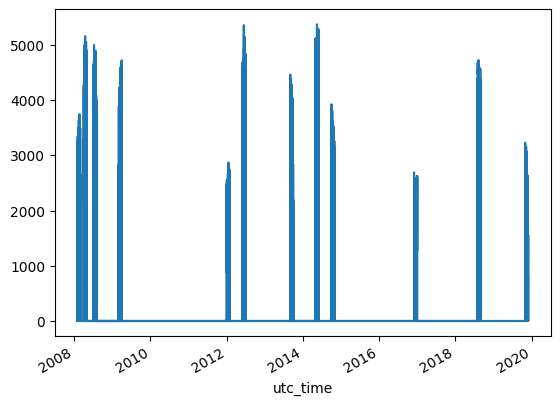

In [ ]:
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# Define the PV system
system = PVSystem(surface_tilt=IP_Tilt_Angle, surface_azimuth=IP_Surface_Azimuth,
                  module_parameters=module,
                  inverter_parameters=inverter,
                  temperature_model_parameters=temperature_model_parameters,
                  modules_per_string=6, strings_per_inverter=2,
                  )

# Create a ModelChain object
mc = ModelChain(system, location, aoi_model='physical')

# Run the model
mc.run_model(weather)
#print(mc.results.cell_temperature)
# Access the results


print(mc.results.dc)
print(mc.results.ac)

mc.results.ac.plot()


In [ ]:
print(mc)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: physical_aoi_loss
  spectral_model: first_solar_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses


utc_time
2012-01-01 00:00:00+00:00    0.0
2012-01-01 01:00:00+00:00    0.0
2012-01-01 02:00:00+00:00    0.0
2012-01-01 03:00:00+00:00    0.0
2012-01-01 04:00:00+00:00    0.0
                            ... 
2016-12-31 19:00:00+00:00    0.0
2016-12-31 20:00:00+00:00    0.0
2016-12-31 21:00:00+00:00    0.0
2016-12-31 22:00:00+00:00    0.0
2016-12-31 23:00:00+00:00    0.0
Name: p_mp, Length: 8760, dtype: float64


(0.0, 168.0)

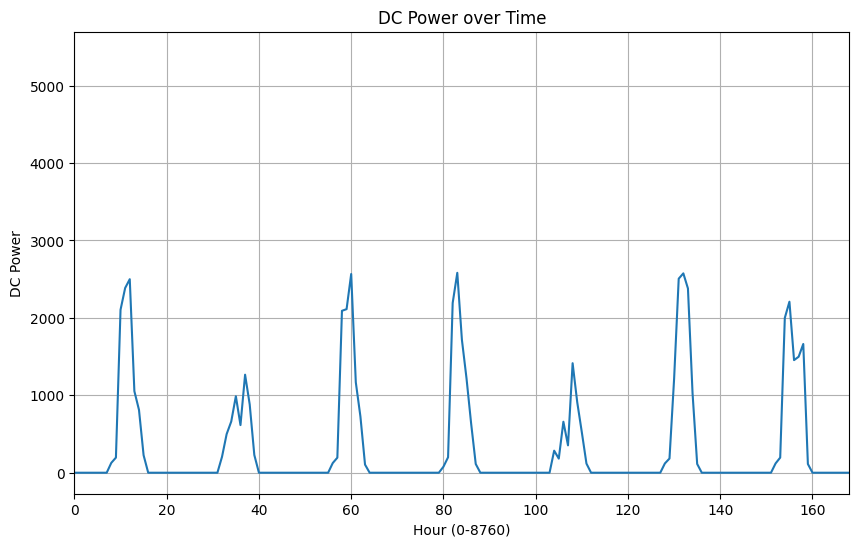

In [ ]:
# prompt: ploter la puissance dc avec les heures du fichier de 0à 8760 en bascisse

dc_power = mc.results.dc['p_mp']
print(dc_power)
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(range(len(dc_power)), dc_power)
plt.xlabel('Hour (0-8760)')
plt.ylabel('DC Power')
plt.title('DC Power over Time')
plt.grid(True)  # Add grid for better readability
plt.xlim(0,24*7) # Set x-axis limits

#plt.show()

In [ ]:
print(dc_power.iloc[15])

225.83864732382915


In [ ]:
#________________________AP Montly Calculation__________________________________
for i in Hours:
    match i:
        case i if i < 744:
            MonthlyDCpower.loc[i, "January"] = (dc_power.iloc[i])
            MonthlyPOA.loc[i, "January"] = (weather['poa_global'].iloc[i])
            MonthlyTemp.loc[i, "January"] = (weather['temp_air'].iloc[i])
            MonthlyRH.loc[i, "January"] = (weather['relative_humidity'].iloc[i])

        case i if 744 <= i < 1416:
            MonthlyDCpower.loc[i-744, "February"] = (dc_power.iloc[i])
            MonthlyPOA.loc[i-744, "February"] = (weather['poa_global'].iloc[i])
            MonthlyTemp.loc[i-744, "February"] = (weather['temp_air'].iloc[i])
            MonthlyRH.loc[i-744, "February"]= (weather['relative_humidity'].iloc[i])
        case i if 1416 <= i < 2160:
            MonthlyDCpower.loc[i-1416, "March"] = (dc_power.iloc[i])
            MonthlyPOA.loc[i-1416, "March"] = (weather['poa_global'].iloc[i])
            MonthlyTemp.loc[i-1416, "March"] = (weather['temp_air'].iloc[i])
            MonthlyRH.loc[i-1416, "March"] = (weather['relative_humidity'].iloc[i])
        case i if 2160 <= i < 2880:
            MonthlyDCpower.loc[i-2160, "April"] = (dc_power.iloc[i])
            MonthlyPOA.loc[i-2160, "April"]  = (weather['poa_global'].iloc[i])
            MonthlyTemp.loc[i-2160, "April"] = (weather['temp_air'].iloc[i])
            MonthlyRH.loc[i-2160, "April"]  = (weather['relative_humidity'].iloc[i])
        case i if 2880 <= i < 3624:
            MonthlyDCpower.loc[i-2880, "May"] = (dc_power.iloc[i])
            MonthlyPOA.loc[i-2880, "May"] = (weather['poa_global'].iloc[i])
            MonthlyTemp.loc[i-2880, "May"] = (weather['temp_air'].iloc[i])
            MonthlyRH.loc[i-2880, "May"] = (weather['relative_humidity'].iloc[i])
        case i if 3624 <= i < 4344:
            MonthlyDCpower.loc[i-3624, "June"] = (dc_power.iloc[i])
            MonthlyPOA.loc[i-3624, "June"] = (weather['poa_global'].iloc[i])
            MonthlyTemp.loc[i-3624, "June"] = (weather['temp_air'].iloc[i])
            MonthlyRH.loc[i-3624, "June"] = (weather['relative_humidity'].iloc[i])
        case i if 4344 <= i < 5088:
            MonthlyDCpower.loc[i-4344, "July"]  = (dc_power.iloc[i])
            MonthlyPOA.loc[i-4344, "July"] = (weather['poa_global'].iloc[i])
            MonthlyTemp.loc[i-4344, "July"] = (weather['temp_air'].iloc[i])
            MonthlyRH.loc[i-4344, "July"] = (weather['relative_humidity'].iloc[i])
        case i if 5088 <= i < 5832:
            MonthlyDCpower.loc[i-5088, "August"] = (dc_power.iloc[i])
            MonthlyPOA.loc[i-5088, "August"] = (weather['poa_global'].iloc[i])
            MonthlyTemp.loc[i-5088, "August"] = (weather['temp_air'].iloc[i])
            MonthlyRH.loc[i-5088, "August"] = (weather['relative_humidity'].iloc[i])
        case i if 5832 <= i < 6552:
            MonthlyDCpower.loc[i-5832, "September"] = (dc_power.iloc[i])
            MonthlyPOA.loc[i-5832, "September"] = (weather['poa_global'].iloc[i])
            MonthlyTemp.loc[i-5832, "September"] = (weather['temp_air'].iloc[i])
            MonthlyRH.loc[i-5832, "September"] = (weather['relative_humidity'].iloc[i])
        case i if 6552 <= i < 7296:
            MonthlyDCpower.loc[i-6552, "October"] = (dc_power.iloc[i])
            MonthlyPOA.loc[i-6552, "October"] = (weather['poa_global'].iloc[i])
            MonthlyTemp.loc[i-6552, "October"] = (weather['temp_air'].iloc[i])
            MonthlyRH.loc[i-6552, "October"] = (weather['relative_humidity'].iloc[i])
        case i if 7296 <= i < 8016:
            MonthlyDCpower.loc[i-7296, "November"] = (dc_power.iloc[i])
            MonthlyPOA.loc[i-7296, "November"] = (weather['poa_global'].iloc[i])
            MonthlyTemp.loc[i-7296, "November"] = (weather['temp_air'].iloc[i])
            MonthlyRH.loc[i-7296, "November"] = (weather['relative_humidity'].iloc[i])
        case i if 8016 <= i < 8760:
            MonthlyDCpower.loc[i-8016, "December"] = (dc_power.iloc[i])
            MonthlyPOA.loc[i-8016, "December"] = (weather['poa_global'].iloc[i])
            MonthlyTemp.loc[i-8016, "December"] = (weather['temp_air'].iloc[i])
            MonthlyRH.loc[i-8016, "December"] = (weather['relative_humidity'].iloc[i])

#print(MonthlyDCpower)

In [ ]:
j=0
for month in Months:
    MonthlyDCpower[month] = MonthlyDCpower[month].sum()
    MonthlyPOA_mean[month] = MonthlyPOA[month].mean()
    MonthlyTemp_mean[month] = MonthlyTemp[month].mean()
    MonthlyRH_mean[month] = MonthlyRH [month].mean()

    match month:
        case "February":
            MonthlyPOA_energy[month] = MonthlyPOA_mean[month] * 672
        case "April" | "June" | "September" | "November":
            MonthlyPOA_energy[month] = MonthlyPOA_mean[month] * 720
        case _:
            MonthlyPOA_energy[month] = MonthlyPOA_mean[month] * 744

    Snowlosses[month] = pvlib.snow.loss_townsend(SnowData["snow_total"][j], SnowData["snow_events"][j], IP_Tilt_Angle, MonthlyRH_mean[j],
                  MonthlyTemp_mean[month] , MonthlyPOA_energy[month], slant_height = 2, lower_edge_height=6,
                  string_factor=0.75, angle_of_repose=40)
    #slant height is 2 meter because of 2 rows of horizontal of pannels each one 1 meter high, edge 6meter high for house with 2 floor
    #O_Monthlypower[month]= (MonthlyACpower_sum[month]*IP_Npanels*(1-Snowlosses[month]))/1000
    #O_Monthlypower[month]= (MonthlyACpower_sum[month]*G_Npanels*)/1000
    j= j+1

In [ ]:
print(Snowlosses)

January      0.093721
February     0.000000
March        0.029399
April        0.000000
May          0.000000
June         0.000000
July         0.000000
August       0.000000
September    0.000000
October      0.000000
November     0.120496
December     0.029053
dtype: float64


In [ ]:
weather_corr = weather.copy()

dc_power_snow = pd.Series()
#________________________AP Montly Calculation__________________________________
iMonth = ''
for i in Hours:
    match i:
        case i if i < 744:
            iMonth = 'January'
        case i if 744 <= i < 1416:
            iMonth = 'February'
        case i if 1416 <= i < 2160:
            iMonth = 'March'
        case i if 2160 <= i < 2880:
            iMonth = 'April'
        case i if 2880 <= i < 3624:
            iMonth = 'May'
        case i if 3624 <= i < 4344:
            iMonth = 'June'
        case i if 4344 <= i < 5088:
            iMonth = 'July'
        case i if 5088 <= i < 5832:
            iMonth = 'August'
        case i if 5832 <= i < 6552:
            iMonth = 'September'
        case i if 6552 <= i < 7296:
            iMonth = 'October'
        case i if 7296 <= i < 8016:
            iMonth = 'November'
        case i if 8016 <= i < 8760:
            iMonth = 'December'
        case __: print("Error!Match Case")

    dc_power_snow[i] = dc_power[i]*(1-Snowlosses[iMonth])
    weather_corr["ghi"][i] *=(1-Snowlosses[iMonth])
    weather_corr["dhi"][i] *=(1-Snowlosses[iMonth])
    weather_corr["dni"][i] *=(1-Snowlosses[iMonth])



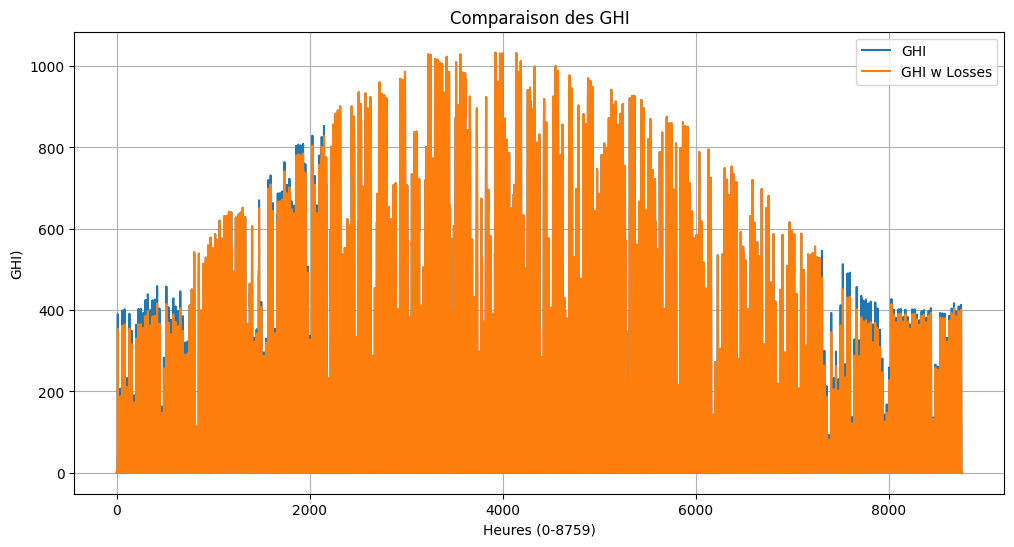

In [ ]:
heures = range(8760)

# Créer le graphique
plt.figure(figsize=(12, 6))

plt.plot(heures, weather["ghi"],label='GHI')
plt.plot(heures, weather_corr["ghi"],label='GHI w Losses')

# Configurer les axes
plt.xlabel('Heures (0-8759)')
plt.ylabel('GHI)')

# Ajouter un titre et une légende
plt.title('Comparaison des GHI')
plt.legend()

# Afficher la grille
plt.grid(True)

# Afficher le graphique
plt.show()

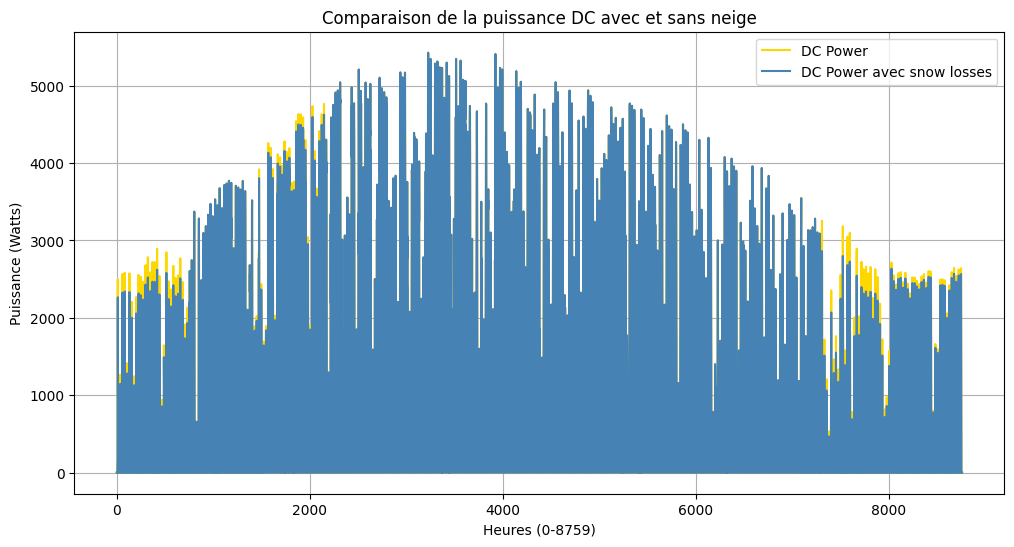

In [ ]:


# Créer le graphique
plt.figure(figsize=(12, 6))
plt.plot(heures, dc_power, label='DC Power',color='gold')
plt.plot(heures, dc_power_snow, label='DC Power avec snow losses',color='steelblue')


# Configurer les axes
plt.xlabel('Heures (0-8759)')
plt.ylabel('Puissance (Watts)')

# Ajouter un titre et une légende
plt.title('Comparaison de la puissance DC avec et sans neige')
plt.legend()

# Afficher la grille
plt.grid(True)

# Afficher le graphique
plt.show()

In [ ]:
print(weather['ghi'].sum())
print(weather_corr['ghi'].sum())

1437494.0
1421680.2337971567


In [ ]:
p_ac = mc.results.ac.copy()

mc2 = ModelChain(system, location, aoi_model='physical')
mc2.run_model(weather_corr)
#print(mc2.results)
p_ac_wloss = mc2.results.ac

print("PAC[kwh]: ",p_ac.sum()/1000)
print("PAC with losses[kwh]: ",p_ac_wloss.sum()/1000)

PAC[kwh]:  7765.316037328609
PAC with losses[kwh]:  7671.081439907631


In [ ]:
print(mc.results.dc.sum())
print(mc2.results.dc.sum())

i_sc    3.313170e+04
v_oc    1.229427e+06
i_mp    3.154077e+04
v_mp    1.066426e+06
p_mp    7.845125e+06
i_x     3.303937e+04
i_xx    2.469756e+04
dtype: float64
i_sc    3.274242e+04
v_oc    1.229144e+06
i_mp    3.116965e+04
v_mp    1.066409e+06
p_mp    7.750254e+06
i_x     3.265121e+04
i_xx    2.441131e+04
dtype: float64


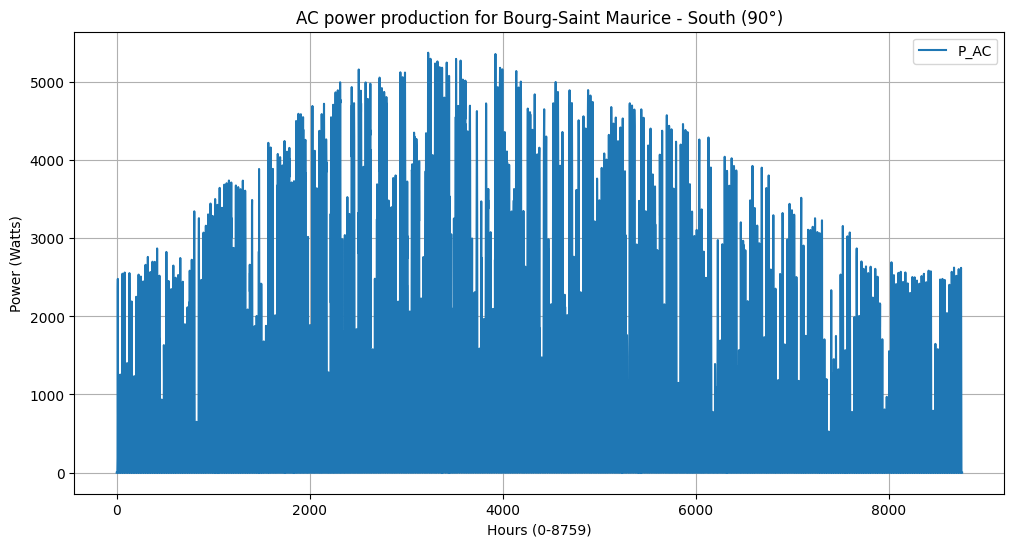

In [ ]:
heures = range(8760)

# Créer le graphique
plt.figure(figsize=(12, 6))



plt.plot(heures, p_ac, label='P_AC')
#plt.plot(heures, p_ac_wloss, label='P_AC w Losses')
# Configurer les axes
plt.xlabel('Hours (0-8759)')
plt.ylabel('Power (Watts)')

# Ajouter un titre et une légende
plt.title('AC power production for Bourg-Saint Maurice - South (90°)')
plt.legend()

# Afficher la grille
plt.grid(True)

# Afficher le graphique
plt.show()

In [ ]:
#print(weather['ghi'].head())
#print(weather_corr['ghi'].head())

#mc.run_model(weather)
#print(mc.weather['ghi'].head())

#mc2.run_model(weather_corr)
#print(mc2.weather['ghi'].head())

**GRAPHS**



In [ ]:
def calculate_monthly_ac_losses(p_ac, p_ac_wloss):
  losses = p_ac - p_ac_wloss  # Calculate losses for each hour
  monthly_results = []

  for month_num in range(1, 13):
      month_name = calendar.month_name[month_num]

      # Filter data for the current month
      month_data_losses = losses[losses.index.month == month_num]
      month_data_production_wloss = p_ac_wloss[p_ac_wloss.index.month == month_num]

      # Calculate losses and production in kWh
      losses_kwh = month_data_losses.sum() / 1000
      production_wloss_kwh = month_data_production_wloss.sum() / 1000

      # Calculate loss percentage
      loss_percentage = (losses_kwh / (production_wloss_kwh + losses_kwh)) * 100 if (production_wloss_kwh + losses_kwh) != 0 else 0

      monthly_results.append([month_name, losses_kwh, production_wloss_kwh, loss_percentage])

  # Create DataFrame
  results_df = pd.DataFrame(monthly_results, columns=['Month', 'AC Losses (kWh)', 'AC Production with Losses (kWh)', 'Loss Percentage (%)'])
  results_df.set_index('Month', inplace=True)

  return results_df

# Example usage:
results_m = calculate_monthly_ac_losses(p_ac, p_ac_wloss)
print(results_m)


           AC Losses (kWh)  AC Production with Losses (kWh)  \
Month                                                         
January          29.683656                       283.268597   
February          0.000000                       492.239225   
March            19.991644                       688.618333   
April             0.000000                       842.384957   
May               0.000000                       959.057060   
June              0.000000                       906.573784   
July              0.000000                       895.439350   
August            0.000000                       842.431253   
September         0.000000                       656.504468   
October           0.000000                       524.062337   
November         34.601412                       249.616044   
December          9.957885                       330.886033   

           Loss Percentage (%)  
Month                           
January               9.485043  
February          

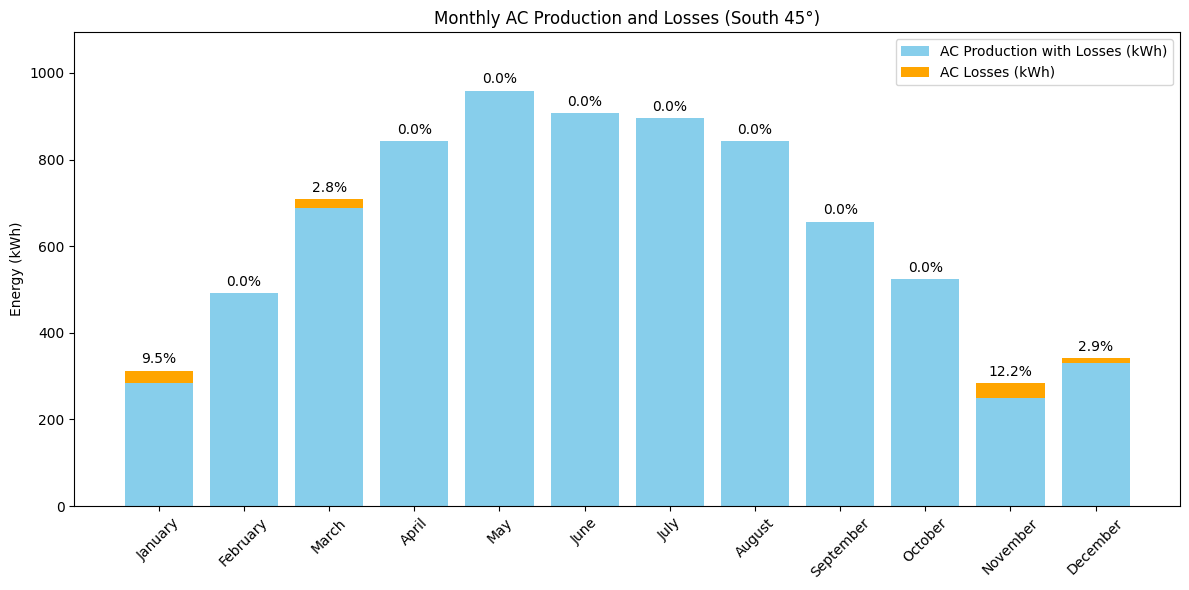

In [ ]:
# Get the data from the DataFrame
months = results_m.index
production = results_m['AC Production with Losses (kWh)']
losses = results_m['AC Losses (kWh)']
loss_percentage = results_m['Loss Percentage (%)']

# Set the width of the bars
bar_width = 0.8
# Create the bar diagram
fig, ax = plt.subplots(figsize=(12, 6))
production_bars = ax.bar(months, production, bar_width, label='AC Production with Losses (kWh)', color='skyblue')
losses_bars = ax.bar(months, losses, bar_width, bottom=production, label='AC Losses (kWh)', color='orange')

# Add labels, title, and legend
ax.set_ylabel('Energy (kWh)')
ax.set_title('Monthly AC Production and Losses (South 45°)')
ax.set_xticks(months)
ax.legend()

# Set the y-axis limits
plt.ylim(0, production.max() + losses.max() + 100) # Adjust 100 to your desired buffer

# Add loss percentage above each bar
for i, month in enumerate(months):
    total_height = production[month] + losses[month]
    ax.text(i, total_height + 10, f'{loss_percentage[month]:.1f}%', ha='center', va='bottom')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
def calculate_weekly_ac_losses(p_ac, p_ac_wloss):
    # Ensure p_ac and p_ac_wloss have DateTimeIndex
    p_ac.index = pd.to_datetime(p_ac.index)
    p_ac_wloss.index = pd.to_datetime(p_ac_wloss.index)

    losses = p_ac - p_ac_wloss  # Calculate losses for each hour
    weekly_results = []  # Initialize weekly_results as an empty list

    for week_num in range(1, 53):  # Changed to 53 to cover all weeks
        # Use week_num directly instead of week_name
        # week_name = calendar.day_name[0]  # 0 represents Monday - No longer needed

        # Filter data for the current week
        # Use .isocalendar().week to get the week number
        week_data_losses = losses[losses.index.isocalendar().week == week_num]
        week_data_production_wloss = p_ac_wloss[p_ac_wloss.index.isocalendar().week == week_num]

        # Calculate losses and production in kWh
        losses_kwh = week_data_losses.sum() / 1000
        production_wloss_kwh = week_data_production_wloss.sum() / 1000

        # Calculate loss percentage
        loss_percentage = (losses_kwh / (production_wloss_kwh + losses_kwh)) * 100 if (production_wloss_kwh + losses_kwh) != 0 else 0

        weekly_results.append([week_num, losses_kwh, production_wloss_kwh, loss_percentage]) # Use week_num here

    # Create DataFrame
    results_df = pd.DataFrame(weekly_results, columns=['Week Number', 'AC Losses (kWh)', 'AC Production with Losses (kWh)', 'Loss Percentage (%)']) # Changed column name
    results_df.set_index('Week Number', inplace=True) # Changed index name

    return results_df

# Example usage:
results_w = calculate_weekly_ac_losses(p_ac, p_ac_wloss)
print(results_w)

             AC Losses (kWh)  AC Production with Losses (kWh)  \
Week Number                                                     
1                   4.869547                        46.082094   
2                   7.977701                        76.433703   
3                   6.892129                        65.860765   
4                   7.622965                        72.862920   
5                   1.447728                        58.931434   
6                   0.000000                       105.011349   
7                   0.000000                       128.847197   
8                   0.000000                       142.681682   
9                   0.332258                        81.272728   
10                  3.020518                       101.278306   
11                  4.285349                       147.420454   
12                  5.857877                       204.646427   
13                  4.730070                       162.154400   
14                  1.765

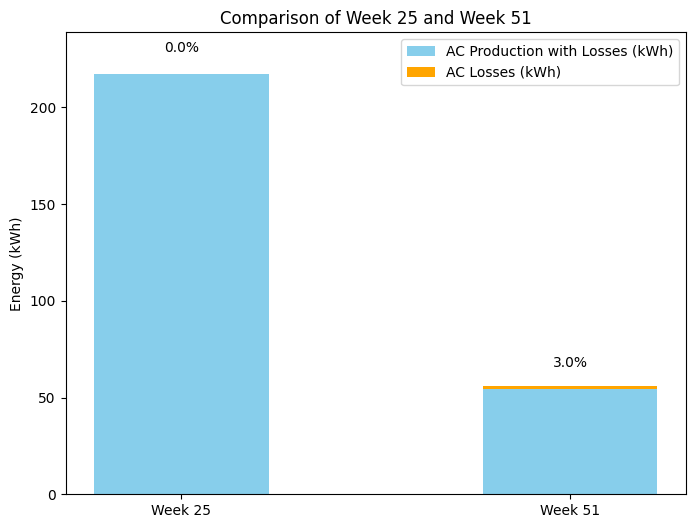

In [ ]:
# Example usage:
results_w = calculate_weekly_ac_losses(p_ac, p_ac_wloss)

# Extract data for week 25 and week 51
week_25_data = results_w.loc[25]
week_51_data = results_w.loc[51]

# Create bar diagram
weeks = ['Week 25', 'Week 51']
losses = [week_25_data['AC Losses (kWh)'], week_51_data['AC Losses (kWh)']]
production = [week_25_data['AC Production with Losses (kWh)'], week_51_data['AC Production with Losses (kWh)']]

fig, ax = plt.subplots(figsize=(8, 6))  # Adjust figure size as needed

width = 0.45  # the width of the bars

# Increase y-axis scale
# Set the y-axis limits
plt.ylim(0, max(production) + max(losses) + 20)


# Changed the order of bars and bottom argument
ax.bar(weeks, production, width, label='AC Production with Losses (kWh)', color='skyblue')  # Production first
ax.bar(weeks, losses, width, bottom=production, label='AC Losses (kWh)', color='orange')  # Losses on top of production

# Add percentage of losses above each bar
for bar, percentage in zip(ax.patches, [week_25_data['Loss Percentage (%)'], week_51_data['Loss Percentage (%)']]): # Updated for both sets of bars
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_y() + height + 10 # Adjust 5 for vertical spacing

    ax.text(x, y, f'{percentage:.1f}%', ha='center', va='bottom')

ax.set_ylabel('Energy (kWh)')
ax.set_title('Comparison of Week 25 and Week 51')
ax.legend()

plt.show()

In [ ]:
def calculate_daily_ac_losses(p_ac, p_ac_wloss):
    # Ensure p_ac and p_ac_wloss have DateTimeIndex
    p_ac.index = pd.to_datetime(p_ac.index)
    p_ac_wloss.index = pd.to_datetime(p_ac_wloss.index)

    losses = p_ac - p_ac_wloss  # Calculate losses for each hour
    daily_results = []  # Initialize daily_results as an empty list

    for day in range(1, 366):  # Changed to 366 to cover all days
        # Filter data for the current day
        day_data_losses = losses[losses.index.dayofyear == day]
        day_data_production_wloss = p_ac_wloss[p_ac_wloss.index.dayofyear == day]

        # Calculate losses and production in kWh
        losses_kwh = day_data_losses.sum() / 1000
        production_wloss_kwh = day_data_production_wloss.sum() / 1000

        # Calculate loss percentage
        loss_percentage = (losses_kwh / (production_wloss_kwh + losses_kwh)) * 100 if (production_wloss_kwh + losses_kwh) != 0 else 0

        daily_results.append([day, losses_kwh, production_wloss_kwh, loss_percentage])

    # Create DataFrame
    results_df = pd.DataFrame(daily_results, columns=['Day of Year', 'AC Losses (kWh)', 'AC Production with Losses (kWh)', 'Loss Percentage (%)'])
    results_df.set_index('Day of Year', inplace=True)

    return results_df

# Example usage:
results_d = calculate_daily_ac_losses(p_ac, p_ac_wloss)
print(results_d)

             AC Losses (kWh)  AC Production with Losses (kWh)  \
Day of Year                                                     
1                   0.873586                         8.402241   
2                   0.509843                         4.731441   
3                   0.848637                         8.112658   
4                   0.816007                         7.793453   
5                   0.422609                         3.917909   
...                      ...                              ...   
361                 0.278151                         9.147263   
362                 0.318995                        10.667188   
363                 0.326071                        10.889546   
364                 0.330544                        11.046513   
365                 0.328597                        11.026935   

             Loss Percentage (%)  
Day of Year                       
1                       9.417878  
2                       9.727445  
3             

In [ ]:
def calculate_hourly_ac_losses(p_ac, p_ac_wloss):
    # Ensure p_ac and p_ac_wloss have DateTimeIndex
    p_ac.index = pd.to_datetime(p_ac.index)
    p_ac_wloss.index = pd.to_datetime(p_ac_wloss.index)

    # Calculate losses for each hour
    losses = p_ac - p_ac_wloss

    # Create a DataFrame with hourly results
    hourly_results = pd.DataFrame({
        'Hour': p_ac.index,
        'AC Losses (W)': losses.values,
        'AC Production with Losses (W)': p_ac_wloss.values,
    })
    hourly_results.set_index('Hour', inplace=True)

    # Clip negative production values to 0
    hourly_results['AC Production with Losses (W)'] = hourly_results['AC Production with Losses (W)'].clip(lower=0)

    # Calculate loss percentage
    hourly_results['Loss Percentage (%)'] = (hourly_results['AC Losses (W)'] /
                                             (hourly_results['AC Production with Losses (W)'] +
                                              hourly_results['AC Losses (W)'])) * 100
    hourly_results['Loss Percentage (%)'] = hourly_results['Loss Percentage (%)'].fillna(0)

    return hourly_results

# Example usage:
results_h = calculate_hourly_ac_losses(p_ac, p_ac_wloss)
print(results_h)




                           AC Losses (W)  AC Production with Losses (W)  \
Hour                                                                      
2012-01-01 00:00:00+00:00            0.0                            0.0   
2012-01-01 01:00:00+00:00            0.0                            0.0   
2012-01-01 02:00:00+00:00            0.0                            0.0   
2012-01-01 03:00:00+00:00            0.0                            0.0   
2012-01-01 04:00:00+00:00            0.0                            0.0   
...                                  ...                            ...   
2016-12-31 19:00:00+00:00            0.0                            0.0   
2016-12-31 20:00:00+00:00            0.0                            0.0   
2016-12-31 21:00:00+00:00            0.0                            0.0   
2016-12-31 22:00:00+00:00            0.0                            0.0   
2016-12-31 23:00:00+00:00            0.0                            0.0   

                        

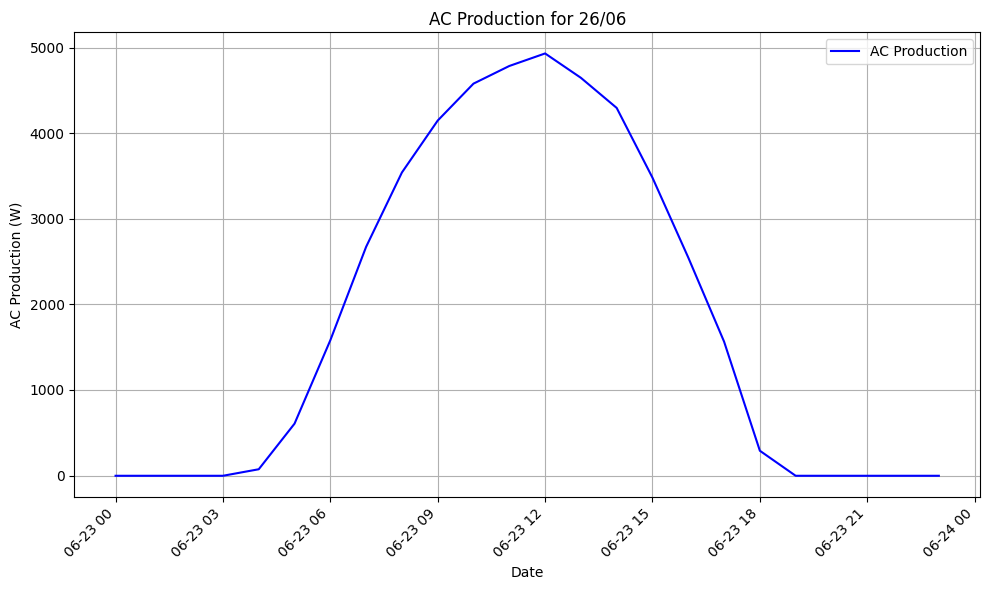

In [ ]:
# Select data for the desired hours
selected_hours_e = p_ac.iloc[4152:4176]

# Create the curve graph
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(selected_hours_e.index, selected_hours_e.values, color='b', label='AC Production')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('AC Production (W)')
plt.title('AC Production for 26/06')
plt.grid(True)
plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
selected_hours_e.to_csv('selected_hours_e.csv')

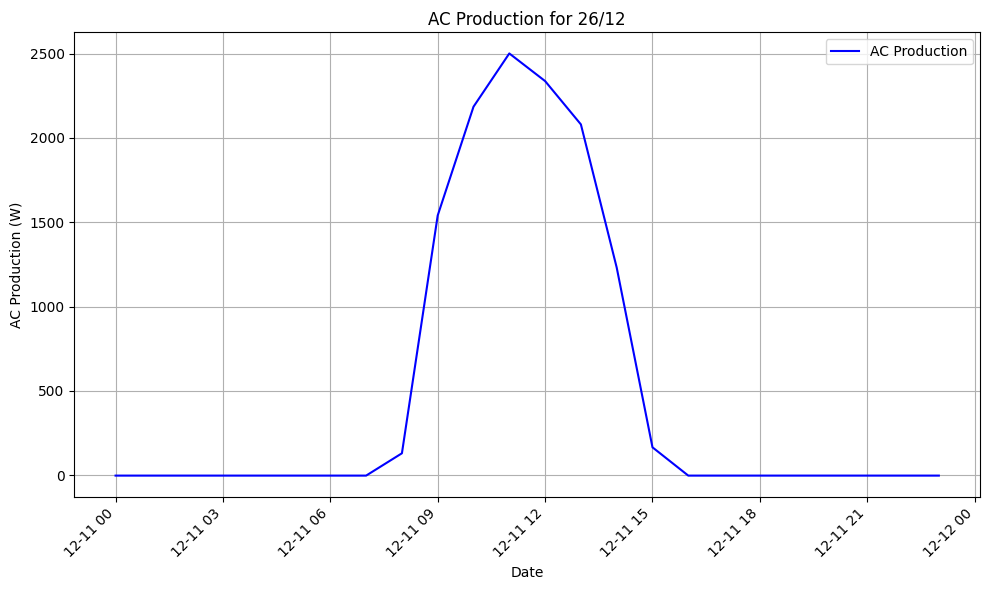

In [ ]:
# Select data for the desired hours
selected_hours_h = p_ac.iloc[8256:8280]


# Create the curve graph
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(selected_hours_h.index, selected_hours_h.values,  color='b', label='AC Production')


# Customize the plot
plt.xlabel('Date')
plt.ylabel('AC Production (W)')
plt.title('AC Production for 26/12')
plt.grid(True)
plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
selected_hours_h.to_csv('selected_hours_h.csv')

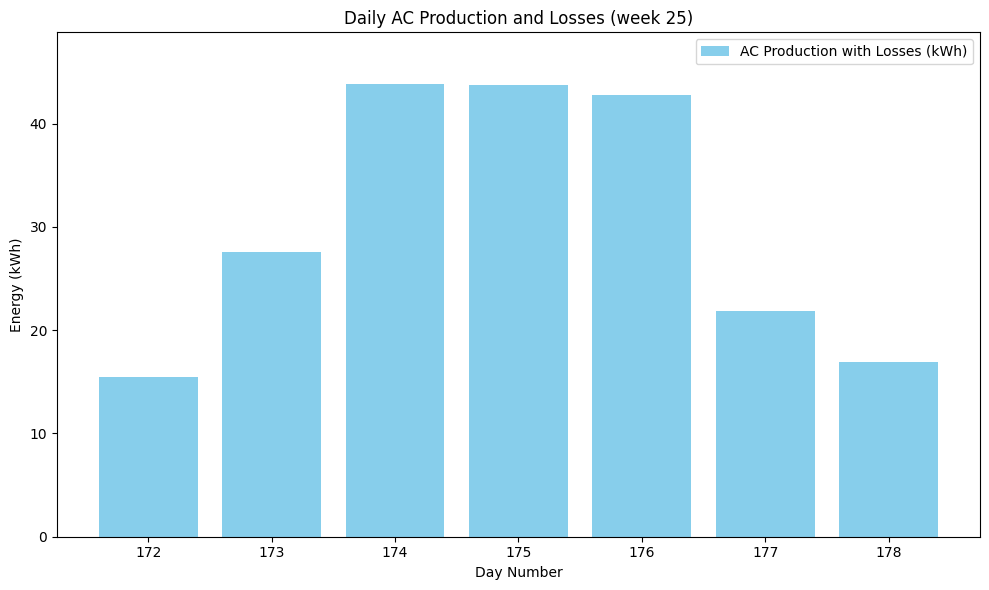

In [ ]:


# Extract data for days 172 to 178
selected_days = results_d.loc[172:178]

# Get the data from the selected days
days = selected_days.index
production = selected_days['AC Production with Losses (kWh)']
losses = selected_days['AC Losses (kWh)']
loss_percentage = selected_days['Loss Percentage (%)']

# Set the width of the bars
bar_width = 0.8

# Create the bar diagram
fig, ax = plt.subplots(figsize=(10, 6))

# Convert 'days' to strings for bar plot
x_pos = np.arange(len(days))  # Create numerical positions for bars
production_bars = ax.bar(x_pos, production, bar_width, label='AC Production with Losses (kWh)', color='skyblue')

# Set x-axis ticks and labels
ax.set_xticks(x_pos)  # Set ticks at numerical positions
ax.set_xticklabels(days.astype(str))  # Set labels as strings

# Add labels, title, and legend
ax.set_ylabel('Energy (kWh)')
ax.set_title('Daily AC Production and Losses (week 25)')
ax.set_xlabel('Day Number')
ax.legend()

# Set the y-axis limits
plt.ylim(0, production.max() + losses.max()+5)


# Show the plot
plt.tight_layout()
plt.show()

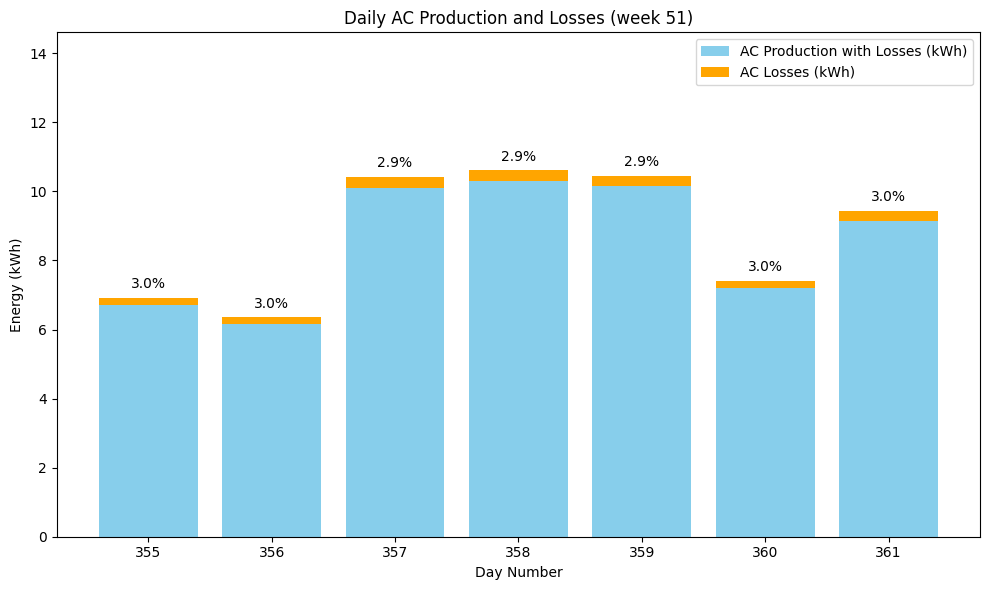

In [ ]:
# Extract data for days 172 to 178
selected_days = results_d.loc[355:361]

# Get the data from the selected days
days = selected_days.index
production = selected_days['AC Production with Losses (kWh)']
losses = selected_days['AC Losses (kWh)']
loss_percentage = selected_days['Loss Percentage (%)']

# Set the width of the bars
bar_width = 0.8

# Create the bar diagram
fig, ax = plt.subplots(figsize=(10, 6))

# Convert 'days' to strings for bar plot
x_pos = np.arange(len(days))  # Create numerical positions for bars
production_bars = ax.bar(x_pos, production, bar_width, label='AC Production with Losses (kWh)', color='skyblue')
losses_bars = ax.bar(x_pos, losses, bar_width, bottom=production, label='AC Losses (kWh)', color='orange')

# Set x-axis ticks and labels
ax.set_xticks(x_pos)  # Set ticks at numerical positions
ax.set_xticklabels(days.astype(str))  # Set labels as strings

# Add labels, title, and legend
ax.set_ylabel('Energy (kWh)')
ax.set_title('Daily AC Production and Losses (week 51)')
ax.set_xlabel('Day Number')
ax.legend()

# Set the y-axis limits
plt.ylim(0, production.max() + losses.max()+4)

# Add loss percentage above each bar
for i, day in enumerate(days):
    total_height = production[day] + losses[day]
    ax.text(i, total_height + 0.2, f'{loss_percentage[day]:.1f}%', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Assuming you uploaded using files.upload()
df1 = pd.read_csv('Hourly AC production Bourg Saint Maurice 23-06 (south 25°).csv')
df2 = pd.read_csv('Hourly AC production Bourg Saint Maurice 23-06 (east 25°).csv')
df3 = pd.read_csv('Hourly AC production Bourg Saint Maurice 23-06 (west 25°).csv')
df4 = pd.read_csv('Hourly AC production Bourg Saint Maurice 23-12 (south 60°).csv')
df5 = pd.read_csv('Hourly AC production Bourg Saint Maurice 23-12 (east 60°).csv')
df6 = pd.read_csv('Hourly AC production Bourg Saint Maurice 23-12 (west 60°).csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Hourly AC production Bourg Saint Maurice 23-06 (south 25°).csv'

In [ ]:
import matplotlib.dates as mdates
# Concatenate the DataFrames
combined_df = pd.concat([
    df1.rename(columns={'0': 'South 25°'})[['South 25°']],
    df2.rename(columns={'0': 'East 25°'})[['East 25°']],
    df3.rename(columns={'0': 'West 25°'})[['West 25°']],
], axis=1)

# Set 'Hour' as index if not already
combined_df['Hour'] = pd.to_datetime(df1['utc_time'], format='%H:%M', errors='coerce').fillna(pd.to_datetime('2023-01-01')) + pd.to_timedelta(df1.index, unit='h')
combined_df.set_index('Hour', inplace=True)


# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(combined_df.index, combined_df['South 25°'], label='South 25°', color='blue')
plt.plot(combined_df.index, combined_df['East 25°'], label='East 25°', color='red')
plt.plot(combined_df.index, combined_df['West 25°'], label='West 25°', color='green')

# Customize the plot
plt.xlabel('Hour')
plt.ylabel('AC Production (W)')
plt.title('Hourly AC Production Comparison - Bourg-Saint-Maurice (June 23rd)')
plt.grid(True)
plt.legend()

# Format x-axis to show only hours
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Set format to HH:MM

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.dates as mdates
# Concatenate the DataFrames
combined_df = pd.concat([
    df4.rename(columns={'0': 'South 60°'})[['South 60°']],
    df5.rename(columns={'0': 'East 60°'})[['East 60°']],
    df6.rename(columns={'0': 'West 60°'})[['West 60°']],
], axis=1)

# Set 'Hour' as index if not already
combined_df['Hour'] = pd.to_datetime(df1['utc_time'], format='%H:%M', errors='coerce').fillna(pd.to_datetime('2023-01-01')) + pd.to_timedelta(df1.index, unit='h')
combined_df.set_index('Hour', inplace=True)


# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(combined_df.index, combined_df['South 60°'], label='South 60°', color='blue')
plt.plot(combined_df.index, combined_df['East 60°'], label='East 60°', color='red')
plt.plot(combined_df.index, combined_df['West 60°'], label='West 60°', color='green')

# Customize the plot
plt.xlabel('Hour')
plt.ylabel('AC Production (W)')
plt.title('Hourly AC Production Comparison - Bourg-Saint-Maurice (December 23rd)')
plt.grid(True)
plt.legend()

# Format x-axis to show only hours
ax = plt.gca()  # Get current axes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Set format to HH:MM

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
mc.ac